In [14]:
# %pip install -q torch

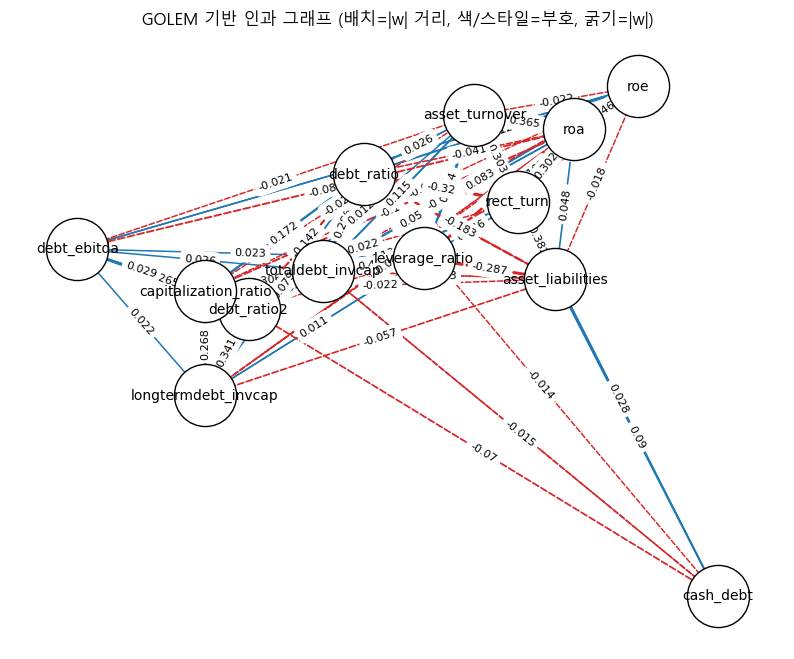

In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# --- 시각화 설정 (선택) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일: df, feature_cols, X_base, y, cols_for_w, cols)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w

# 1) 표준화 데이터 (GOLEM은 연속 최적화에서 스케일 영향 ↓)
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(Z, dtype=torch.float32, device=device)

# 2) GOLEM(EV) 목적함수 구성
#    - 재구성오차(0.5/n ||X - XW||_F^2)
#    - L1 (sparsity), L2 (ridge)
#    - 비순환 제약: h(W)=tr(exp(W∘W)) - d  (∘: elementwise)
#    - Augmented Lagrangian: μ*h + (ρ/2)h^2
lambda1 = 2e-2   # L1 sparsity (필요시 조정)
lambda2 = 5e-2   # L2 ridge     (필요시 조정)
lr = 2e-2
inner_steps = 1500   # 내부(Adam) 반복
max_outer = 8        # 바깥(라그랑주/패널티 갱신) 반복
h_tol = 1e-8
mu = 1.0
rho = 1.0

W_param = nn.Parameter(torch.zeros(d, d, device=device))
I = torch.eye(d, device=device)
mask_offdiag = (1.0 - torch.eye(d, device=device))  # 대각선 0 유지용 마스크
optimizer = optim.Adam([W_param], lr=lr)

def acyclicity(W_eff: torch.Tensor) -> torch.Tensor:
    M = W_eff * W_eff  # elementwise square
    return torch.trace(torch.matrix_exp(M)) - d

def loss_fn(W_eff: torch.Tensor) -> torch.Tensor:
    # 재구성오차
    recon = 0.5 / n * torch.sum((X_t - X_t @ W_eff) ** 2)
    # 정규화
    l1 = lambda1 * torch.sum(torch.abs(W_eff))
    l2 = 0.5 * lambda2 * torch.sum(W_eff ** 2)
    # 비순환
    h = acyclicity(W_eff)
    aug = mu * h + 0.5 * rho * h * h
    return recon + l1 + l2 + aug, h, recon

best_loss = float('inf')
with torch.enable_grad():
    for outer in range(max_outer):
        for step in range(inner_steps):
            optimizer.zero_grad()
            W_eff = W_param * mask_offdiag  # 대각 0 강제
            loss, h_val, recon = loss_fn(W_eff)
            loss.backward()
            optimizer.step()

            # 대각 0 강제(수치오차 cleanup)
            with torch.no_grad():
                W_param.data = W_param.data * mask_offdiag

            if loss.item() < best_loss:
                best_loss = loss.item()

        # AugLag 업데이트
        with torch.no_grad():
            W_eff = W_param * mask_offdiag
            h_curr = acyclicity(W_eff).item()
        if h_curr <= h_tol:
            # 충분히 DAG에 가까우면 종료
            break
        mu = mu + rho * h_curr
        rho *= 10.0  # 점진적 패널티 강화

# 3) 결과 행렬 W 추출 (numpy)
W_golem = (W_param * mask_offdiag).detach().cpu().numpy()

# 4) 시각화 파라미터
USE_QUANTILE = False     # True면 분위수 임계 사용
W_THRESHOLD = 0.01       # |W| > 0.01
W_ABS_QUANTILE = 0.90    # USE_QUANTILE=True일 때 상위 10%

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W_golem)

# 5) 그래프 구성 (부호 유지), 레이아웃은 |w| 기반 양의 '거리'로 안정화
G = nx.DiGraph()
edges_all = []
for i in range(d):
    for j in range(d):
        if i == j:
            continue
        w = float(W_golem[i, j])  # i <- j
        if abs(w) > thr:
            u = cols[j]  # parent
            v = cols[i]  # child
            edges_all.append((u, v, w))
            G.add_edge(u, v, weight=round(w, 3))

# 배치용 보조 그래프(H): 거리=1/(|w|+ε)
eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# 부호/크기 스타일
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("GOLEM 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()

W = W_golem


[GOLEM] outer=1/8, h=1.692e-01, best_loss=3.634417
[GOLEM] outer=2/8, h=9.340e-02, best_loss=3.634417
[GOLEM] outer=3/8, h=3.478e-02, best_loss=3.634417
[GOLEM] outer=4/8, h=9.713e-03, best_loss=3.634417
[GOLEM] outer=5/8, h=2.401e-03, best_loss=3.634417
[GOLEM] outer=6/8, h=6.285e-04, best_loss=3.634417
[GOLEM] outer=7/8, h=1.431e-04, best_loss=3.634417
[GOLEM] outer=8/8, h=5.817e-05, best_loss=3.634417
[CSV] saved: runs_golem_lightgbm_35\baseline_edges_top35.csv (rows=35)
[CSV] saved: runs_golem_lightgbm_35\randW_edges_top35.csv (rows=35)
[CSV] saved: runs_golem_lightgbm_35\randEdge_edges_top35.csv (rows=35)
[baseline:O] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.920933	valid_0's binary_logloss: 0.0914904
[baseline:O] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.953858	valid_0's binary_logloss: 0.105681
[baseline:O] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.928164	valid_0's binary_logloss: 0.121308
[baseline:O] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.939224	valid_0's binary_logloss: 0.0781649
[baseline:O] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[12]	valid_0's auc: 0.934356	valid_0's binary_logloss: 0.404145
[baseline:O] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.948507	valid_0's binary_logloss: 0.0898579
[baseline:O] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[39]	valid_0's auc: 0.925967	valid_0's binary_logloss: 0.198154
[baseline:O] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[148]	valid_0's auc: 0.924012	valid_0's binary_logloss: 0.080701
[baseline:O] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.927801	valid_0's binary_logloss: 0.132482
[baseline:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[28]	valid_0's auc: 0.933186	valid_0's binary_logloss: 0.22117
[baseline:F(m)] fold 2/10 ...


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.920115	valid_0's binary_logloss: 0.185967
[baseline:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train 

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[23]	valid_0's auc: 0.946302	valid_0's binary_logloss: 0.269793
[baseline:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[125]	valid_0's auc: 0.938799	valid_0's binary_logloss: 0.0729987
[baseline:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.936494	valid_0's binary_logloss: 0.0799285
[baseline:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.93266	valid_0's binary_logloss: 0.072643
[baseline:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[44]	valid_0's auc: 0.954333	valid_0's binary_logloss: 0.14379
[baseline:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.930398	valid_0's binary_logloss: 0.258795
[baseline:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[145]	valid_0's auc: 0.932794	valid_0's binary_logloss: 0.0682585
[baseline:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[155]	valid_0's auc: 0.930602	valid_0's binary_logloss: 0.0751297
[baseline:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.933367	valid_0's binary_logloss: 0.0899369
[baseline:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[161]	valid_0's auc: 0.929215	valid_0's binary_logloss: 0.0704449
[baseline:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.949675	valid_0's binary_logloss: 0.258656
[baseline:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11959
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[49]	valid_0's auc: 0.93241	valid_0's binary_logloss: 0.14222
[baseline:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11957
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[158]	valid_0's auc: 0.934159	valid_0's binary_logloss: 0.0732984
[baseline:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[151]	valid_0's auc: 0.936902	valid_0's binary_logloss: 0.0628882
[baseline:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.949281	valid_0's binary_logloss: 0.0895343
[baseline:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11954
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.927586	valid_0's binary_logloss: 0.175828
[baseline:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[119]	valid_0's auc: 0.934539	valid_0's binary_logloss: 0.0710739
[baseline:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[89]	valid_0's auc: 0.928526	valid_0's binary_logloss: 0.090569
[baseline:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.940843	valid_0's binary_logloss: 0.209379
[baseline:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[9]	valid_0's auc: 0.912518	valid_0's binary_logloss: 0.443282
[baseline:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[51]	valid_0's auc: 0.948279	valid_0's binary_logloss: 0.137709
[baseline:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[131]	valid_0's auc: 0.939327	valid_0's binary_logloss: 0.0727735
[baseline:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[120]	valid_0's auc: 0.936078	valid_0's binary_logloss: 0.0773926
[baseline:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[137]	valid_0's auc: 0.932347	valid_0's binary_logloss: 0.0674752
[baseline:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[142]	valid_0's auc: 0.949009	valid_0's binary_logloss: 0.0621932
[baseline:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[28]	valid_0's auc: 0.935904	valid_0's binary_logloss: 0.226737
[baseline:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[109]	valid_0's auc: 0.935416	valid_0's binary_logloss: 0.0724282
[baseline:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[108]	valid_0's auc: 0.92692	valid_0's binary_logloss: 0.0843001
[baseline:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[85]	valid_0's auc: 0.937568	valid_0's binary_logloss: 0.0826842
[baseline:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[179]	valid_0's auc: 0.927663	valid_0's binary_logloss: 0.0722481
[baseline:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[48]	valid_0's auc: 0.945221	valid_0's binary_logloss: 0.143323
[baseline:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11959
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[117]	valid_0's auc: 0.938333	valid_0's binary_logloss: 0.0739918
[baseline:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11957
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.937434	valid_0's binary_logloss: 0.0814969
[baseline:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[173]	valid_0's auc: 0.933953	valid_0's binary_logloss: 0.0636705
[baseline:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[94]	valid_0's auc: 0.950105	valid_0's binary_logloss: 0.0755964
[baseline:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11954
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[20]	valid_0's auc: 0.92996	valid_0's binary_logloss: 0.289078
[baseline:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.93134	valid_0's binary_logloss: 0.0723175
[baseline:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[156]	valid_0's auc: 0.929967	valid_0's binary_logloss: 0.075406
[baseline:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[109]	valid_0's auc: 0.940172	valid_0's binary_logloss: 0.0722975
[baseline:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[181]	valid_0's auc: 0.916679	valid_0's binary_logloss: 0.0740307
[baseline:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[132]	valid_0's auc: 0.945751	valid_0's binary_logloss: 0.0640954
[baseline:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[119]	valid_0's auc: 0.936705	valid_0's binary_logloss: 0.0744271
[baseline:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[164]	valid_0's auc: 0.930589	valid_0's binary_logloss: 0.075585
[baseline:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.923296	valid_0's binary_logloss: 0.0736101
[baseline:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[113]	valid_0's auc: 0.948982	valid_0's binary_logloss: 0.0676288
[baseline:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[28]	valid_0's auc: 0.923059	valid_0's binary_logloss: 0.229913
[baseline:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[180]	valid_0's auc: 0.940235	valid_0's binary_logloss: 0.0668224
[baseline:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[127]	valid_0's auc: 0.927381	valid_0's binary_logloss: 0.0789472
[baseline:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20880
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[85]	valid_0's auc: 0.930674	valid_0's binary_logloss: 0.0833673
[baseline:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20876
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[172]	valid_0's auc: 0.926182	valid_0's binary_logloss: 0.0707001
[baseline:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[32]	valid_0's auc: 0.947733	valid_0's binary_logloss: 0.205996
[baseline:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20884
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[160]	valid_0's auc: 0.938092	valid_0's binary_logloss: 0.0693965
[baseline:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20882
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[179]	valid_0's auc: 0.933716	valid_0's binary_logloss: 0.075656
[baseline:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20876
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[150]	valid_0's auc: 0.937103	valid_0's binary_logloss: 0.0653194
[baseline:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20883
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.950154	valid_0's binary_logloss: 0.0822679
[baseline:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20879
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.923383	valid_0's binary_logloss: 0.189797
[baseline:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[146]	valid_0's auc: 0.935448	valid_0's binary_logloss: 0.067512
[baseline:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20883
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[184]	valid_0's auc: 0.928929	valid_0's binary_logloss: 0.0750845
[CSV] saved: runs_golem_lightgbm_35\baseline_report.csv
[randW:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[28]	valid_0's auc: 0.933186	valid_0's binary_logloss: 0.22117
[randW:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[36]	valid_0's auc: 0.920115	valid_0's binary_logloss: 0.185967
[randW:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[23]	valid_0's auc: 0.946302	valid_0's binary_logloss: 0.269793
[randW:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[125]	valid_0's auc: 0.938799	valid_0's binary_logloss: 0.0729987
[randW:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.936494	valid_0's binary_logloss: 0.0799285
[randW:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.93266	valid_0's binary_logloss: 0.072643
[randW:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[44]	valid_0's auc: 0.954333	valid_0's binary_logloss: 0.14379
[randW:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.930398	valid_0's binary_logloss: 0.258795
[randW:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[145]	valid_0's auc: 0.932794	valid_0's binary_logloss: 0.0682585
[randW:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[155]	valid_0's auc: 0.930602	valid_0's binary_logloss: 0.0751297
[randW:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.933367	valid_0's binary_logloss: 0.0899369
[randW:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[161]	valid_0's auc: 0.929215	valid_0's binary_logloss: 0.0704449
[randW:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.949675	valid_0's binary_logloss: 0.258656
[randW:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11959
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[49]	valid_0's auc: 0.93241	valid_0's binary_logloss: 0.14222
[randW:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11957
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[158]	valid_0's auc: 0.934159	valid_0's binary_logloss: 0.0732984
[randW:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[151]	valid_0's auc: 0.936902	valid_0's binary_logloss: 0.0628882
[randW:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.949281	valid_0's binary_logloss: 0.0895343
[randW:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11954
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.927586	valid_0's binary_logloss: 0.175828
[randW:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[119]	valid_0's auc: 0.934539	valid_0's binary_logloss: 0.0710739
[randW:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[89]	valid_0's auc: 0.928526	valid_0's binary_logloss: 0.090569
[randW:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.935716	valid_0's binary_logloss: 0.0898681
[randW:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[11]	valid_0's auc: 0.915361	valid_0's binary_logloss: 0.408165
[randW:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[87]	valid_0's auc: 0.948525	valid_0's binary_logloss: 0.0829624
[randW:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.937116	valid_0's binary_logloss: 0.0787918
[randW:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[117]	valid_0's auc: 0.928602	valid_0's binary_logloss: 0.0789274
[randW:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8924
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[27]	valid_0's auc: 0.92839	valid_0's binary_logloss: 0.235778
[randW:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.953581	valid_0's binary_logloss: 0.0832796
[randW:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[123]	valid_0's auc: 0.924978	valid_0's binary_logloss: 0.0803413
[randW:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[124]	valid_0's auc: 0.935783	valid_0's binary_logloss: 0.0706136
[randW:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[86]	valid_0's auc: 0.92849	valid_0's binary_logloss: 0.094926
[randW:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.934468	valid_0's binary_logloss: 0.0803444
[randW:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[169]	valid_0's auc: 0.931063	valid_0's binary_logloss: 0.0691
[randW:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[42]	valid_0's auc: 0.951501	valid_0's binary_logloss: 0.161598
[randW:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11959
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[133]	valid_0's auc: 0.943702	valid_0's binary_logloss: 0.0691538
[randW:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11957
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[104]	valid_0's auc: 0.934002	valid_0's binary_logloss: 0.0790508
[randW:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.941693	valid_0's binary_logloss: 0.069583
[randW:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[79]	valid_0's auc: 0.948199	valid_0's binary_logloss: 0.0847925
[randW:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11954
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[40]	valid_0's auc: 0.929376	valid_0's binary_logloss: 0.1661
[randW:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[85]	valid_0's auc: 0.930025	valid_0's binary_logloss: 0.0830743
[randW:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[114]	valid_0's auc: 0.927501	valid_0's binary_logloss: 0.0803965
[randW:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[62]	valid_0's auc: 0.93653	valid_0's binary_logloss: 0.107538
[randW:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[165]	valid_0's auc: 0.915524	valid_0's binary_logloss: 0.0742448
[randW:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[99]	valid_0's auc: 0.951425	valid_0's binary_logloss: 0.0740919
[randW:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[186]	valid_0's auc: 0.935125	valid_0's binary_logloss: 0.0712954
[randW:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[126]	valid_0's auc: 0.931394	valid_0's binary_logloss: 0.0773289
[randW:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17849
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[114]	valid_0's auc: 0.932942	valid_0's binary_logloss: 0.0737216
[randW:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.952418	valid_0's binary_logloss: 0.0892325
[randW:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.921831	valid_0's binary_logloss: 0.217221
[randW:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.933533	valid_0's binary_logloss: 0.0741184
[randW:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[150]	valid_0's auc: 0.925296	valid_0's binary_logloss: 0.0796779
[randW:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20880
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[100]	valid_0's auc: 0.934486	valid_0's binary_logloss: 0.0747373
[randW:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20876
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[172]	valid_0's auc: 0.927774	valid_0's binary_logloss: 0.0715663
[randW:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.953105	valid_0's binary_logloss: 0.273839
[randW:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20884
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[144]	valid_0's auc: 0.937327	valid_0's binary_logloss: 0.0701411
[randW:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20882
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[20]	valid_0's auc: 0.910601	valid_0's binary_logloss: 0.288079
[randW:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.933624	valid_0's binary_logloss: 0.184596
[randW:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20883
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.949353	valid_0's binary_logloss: 0.122527
[randW:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20879
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[59]	valid_0's auc: 0.927401	valid_0's binary_logloss: 0.122348
[randW:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[124]	valid_0's auc: 0.937949	valid_0's binary_logloss: 0.0692519
[randW:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20883
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[81]	valid_0's auc: 0.926853	valid_0's binary_logloss: 0.0946396
[CSV] saved: runs_golem_lightgbm_35\randW_report.csv
[randEdge:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[44]	valid_0's auc: 0.932011	valid_0's binary_logloss: 0.15971
[randEdge:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[105]	valid_0's auc: 0.909878	valid_0's binary_logloss: 0.0926072
[randEdge:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[151]	valid_0's auc: 0.951693	valid_0's binary_logloss: 0.0634661
[randEdge:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.910554	valid_0's binary_logloss: 0.101715
[randEdge:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[93]	valid_0's auc: 0.917596	valid_0's binary_logloss: 0.0934113
[randEdge:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[108]	valid_0's auc: 0.925211	valid_0's binary_logloss: 0.0782317
[randEdge:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.949149	valid_0's binary_logloss: 0.107263
[randEdge:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[81]	valid_0's auc: 0.929282	valid_0's binary_logloss: 0.10617
[randEdge:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[132]	valid_0's auc: 0.911963	valid_0's binary_logloss: 0.0782916
[randEdge:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[2]	valid_0's auc: 0.907115	valid_0's binary_logloss: 0.620867
[randEdge:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[7]	valid_0's auc: 0.930801	valid_0's binary_logloss: 0.483547
[randEdge:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[174]	valid_0's auc: 0.92352	valid_0's binary_logloss: 0.0774478
[randEdge:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[127]	valid_0's auc: 0.956843	valid_0's binary_logloss: 0.0635763
[randEdge:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11959
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[121]	valid_0's auc: 0.927269	valid_0's binary_logloss: 0.0817923
[randEdge:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11957
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[132]	valid_0's auc: 0.927403	valid_0's binary_logloss: 0.075233
[randEdge:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[88]	valid_0's auc: 0.935465	valid_0's binary_logloss: 0.0840141
[randEdge:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[55]	valid_0's auc: 0.955778	valid_0's binary_logloss: 0.120181
[randEdge:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11954
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[76]	valid_0's auc: 0.920589	valid_0's binary_logloss: 0.108001
[randEdge:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[40]	valid_0's auc: 0.920428	valid_0's binary_logloss: 0.169734
[randEdge:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[7]	valid_0's auc: 0.918356	valid_0's binary_logloss: 0.484966
[randEdge:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[66]	valid_0's auc: 0.927032	valid_0's binary_logloss: 0.111565
[randEdge:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[147]	valid_0's auc: 0.922768	valid_0's binary_logloss: 0.0811502
[randEdge:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[67]	valid_0's auc: 0.95516	valid_0's binary_logloss: 0.109945
[randEdge:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[59]	valid_0's auc: 0.905124	valid_0's binary_logloss: 0.138588
[randEdge:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[94]	valid_0's auc: 0.930128	valid_0's binary_logloss: 0.0898688
[randEdge:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.922575	valid_0's binary_logloss: 0.0878201
[randEdge:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's auc: 0.947872	valid_0's binary_logloss: 0.124303
[randEdge:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.930763	valid_0's binary_logloss: 0.0995602
[randEdge:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[86]	valid_0's auc: 0.912276	valid_0's binary_logloss: 0.0950048
[randEdge:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[2]	valid_0's auc: 0.909858	valid_0's binary_logloss: 0.620411
[randEdge:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[36]	valid_0's auc: 0.926862	valid_0's binary_logloss: 0.185523
[randEdge:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[144]	valid_0's auc: 0.931228	valid_0's binary_logloss: 0.0775873
[randEdge:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[68]	valid_0's auc: 0.959263	valid_0's binary_logloss: 0.104811
[randEdge:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11959
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[79]	valid_0's auc: 0.927748	valid_0's binary_logloss: 0.10363
[randEdge:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11957
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[146]	valid_0's auc: 0.933814	valid_0's binary_logloss: 0.0718227
[randEdge:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11951
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[21]	valid_0's auc: 0.93375	valid_0's binary_logloss: 0.280353
[randEdge:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[63]	valid_0's auc: 0.957532	valid_0's binary_logloss: 0.105797
[randEdge:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11954
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[45]	valid_0's auc: 0.917099	valid_0's binary_logloss: 0.156054
[randEdge:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11950
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[31]	valid_0's auc: 0.915307	valid_0's binary_logloss: 0.207829
[randEdge:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[51]	valid_0's auc: 0.92124	valid_0's binary_logloss: 0.140237
[randEdge:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[66]	valid_0's auc: 0.920553	valid_0's binary_logloss: 0.113076
[randEdge:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[145]	valid_0's auc: 0.91339	valid_0's binary_logloss: 0.0836865
[randEdge:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[107]	valid_0's auc: 0.950279	valid_0's binary_logloss: 0.0754276
[randEdge:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[115]	valid_0's auc: 0.902021	valid_0's binary_logloss: 0.0899053
[randEdge:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.918106	valid_0's binary_logloss: 0.0887103
[randEdge:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.925269	valid_0's binary_logloss: 0.0755496
[randEdge:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.947604	valid_0's binary_logloss: 0.129207
[randEdge:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[67]	valid_0's auc: 0.920039	valid_0's binary_logloss: 0.120402
[randEdge:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's auc: 0.89491	valid_0's binary_logloss: 0.654426
[randEdge:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[4]	valid_0's auc: 0.914607	valid_0's binary_logloss: 0.559258
[randEdge:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20880
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[11]	valid_0's auc: 0.928671	valid_0's binary_logloss: 0.406054
[randEdge:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20876
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[184]	valid_0's auc: 0.920558	valid_0's binary_logloss: 0.0780984
[randEdge:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[59]	valid_0's auc: 0.953058	valid_0's binary_logloss: 0.121161
[randEdge:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20884
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.926298	valid_0's binary_logloss: 0.0880809
[randEdge:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20882
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[142]	valid_0's auc: 0.932866	valid_0's binary_logloss: 0.0731508
[randEdge:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20876
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[114]	valid_0's auc: 0.935761	valid_0's binary_logloss: 0.0710239
[randEdge:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20883
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[53]	valid_0's auc: 0.953595	valid_0's binary_logloss: 0.123539
[randEdge:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20879
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[107]	valid_0's auc: 0.920459	valid_0's binary_logloss: 0.0897201
[randEdge:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20875
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[167]	valid_0's auc: 0.92888	valid_0's binary_logloss: 0.0755912
[randEdge:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20883
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.904314	valid_0's binary_logloss: 0.118536
[CSV] saved: runs_golem_lightgbm_35\randEdge_report.csv
[CSV] saved: runs_golem_lightgbm_35\all_reports.csv


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


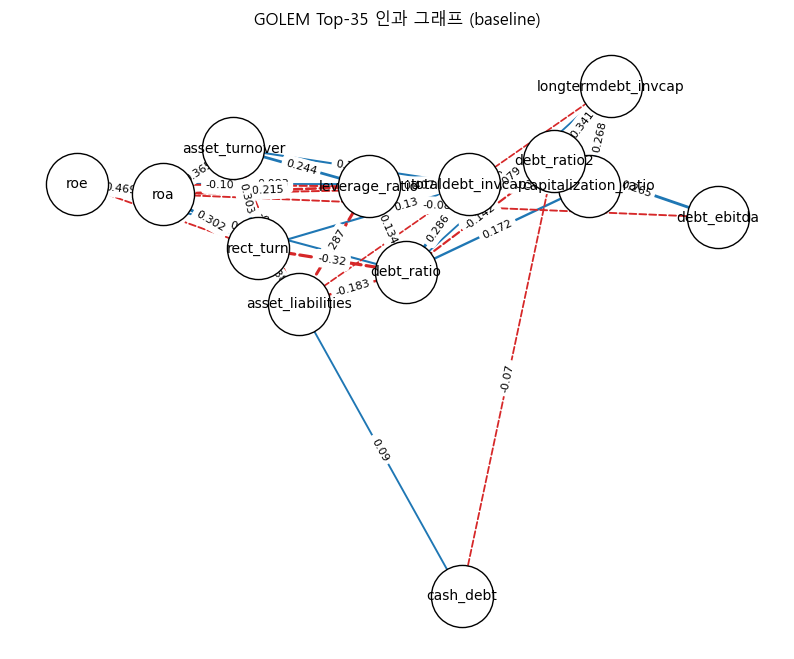

In [16]:
# ============================================================
# GOLEM 학습 → Top-K 고정 → randW / randEdge → LGBM CV Report
# 저장 경로: runs_golem_lightgbm_35/
# 산출물:
#   - baseline_edges_top{K}.csv
#   - randW_edges_top{K}.csv
#   - randEdge_edges_top{K}.csv
#   - baseline_report.csv, randW_report.csv, randEdge_report.csv
#   - all_reports.csv (통합)
# ============================================================

import os, random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional

# ML / CV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# GOLEM (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim

# (선택) 시각화
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# ------------------ 설정 ------------------
DATA_PATH   = "training_data.csv"
ID_COL      = "Unnamed: 0"
LABEL_COL   = "label"

TOP_K       = 35       # Top-K 엣지 수
RANDOM_STATE= 42
RANDW_STD   = 1.0      # randW, randEdge 가중치 표준편차 (N(0, RANDW_STD^2))

PRINT_PROGRESS = True

LGBM_PARAMS = dict(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary",
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
EARLY_STOPPING_ROUNDS = 50

# GOLEM 하이퍼파라미터
lambda1 = 2e-2   # L1 sparsity
lambda2 = 5e-2   # L2 ridge
lr = 2e-2
inner_steps = 1500
max_outer   = 8
h_tol       = 1e-8
mu0, rho0   = 1.0, 1.0
# -----------------------------------------

# 저장 경로
OUT_DIR = Path("runs_golem_lightgbm_35")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 고정 시드
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# 0) 데이터 로드
df = pd.read_csv(DATA_PATH)
feature_cols = df.drop(columns=[ID_COL, LABEL_COL]).columns
X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int)
cols = list(feature_cols)

# 1) 표준화 데이터 (GOLEM 입력)
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(Z, dtype=torch.float32, device=device)

# 2) GOLEM(EV) 목적함수 & 학습
W_param = nn.Parameter(torch.zeros(d, d, device=device))
mask_offdiag = (1.0 - torch.eye(d, device=device))
optimizer = optim.Adam([W_param], lr=lr)

def acyclicity(W_eff: torch.Tensor) -> torch.Tensor:
    M = W_eff * W_eff  # elementwise square
    return torch.trace(torch.matrix_exp(M)) - d

def loss_fn(W_eff: torch.Tensor, mu: float, rho: float):
    recon = 0.5 / n * torch.sum((X_t - X_t @ W_eff) ** 2)
    l1 = lambda1 * torch.sum(torch.abs(W_eff))
    l2 = 0.5 * lambda2 * torch.sum(W_eff ** 2)
    h = acyclicity(W_eff)
    aug = mu * h + 0.5 * rho * h * h
    return recon + l1 + l2 + aug, h, recon

best_loss = float('inf')
mu, rho = mu0, rho0

with torch.enable_grad():
    for outer in range(max_outer):
        for step in range(inner_steps):
            optimizer.zero_grad()
            W_eff = W_param * mask_offdiag
            loss, h_val, recon = loss_fn(W_eff, mu, rho)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                W_param.data = W_param.data * mask_offdiag
            if loss.item() < best_loss:
                best_loss = loss.item()

        with torch.no_grad():
            W_eff = W_param * mask_offdiag
            h_curr = acyclicity(W_eff).item()
        if PRINT_PROGRESS:
            print(f"[GOLEM] outer={outer+1}/{max_outer}, h={h_curr:.3e}, best_loss={best_loss:.6f}")
        if h_curr <= h_tol:
            break
        mu = mu + rho * h_curr
        rho *= 10.0

# 3) baseline W 추출 (i <- j)
W_baseline = (W_param * mask_offdiag).detach().cpu().numpy()

# -------- 유틸 함수들 --------
def pick_top_k_pairs_ij(W: np.ndarray, K: int) -> List[Tuple[int, int]]:
    """|W[i,j]| 상위 K개 (i=child, j=parent) 인덱스 쌍 반환"""
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j: 
                continue
            w = W[i, j]
            if w == 0.0: 
                continue
            flat.append((i, j, abs(w)))
    flat.sort(key=lambda t: t[2], reverse=True)
    return [(i, j) for (i, j, _) in flat[:K]]

def edges_uv_from_pairs(pairs_ij: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
    """(i(child), j(parent)) → (u=parent=j, v=child=i)"""
    return [(j, i) for (i, j) in pairs_ij]

def save_edges_to_csv(W: np.ndarray,
                      edges_uv: List[Tuple[int,int]],
                      cols: List[str],
                      csv_path: Path,
                      weights_override: Optional[Dict[Tuple[int,int], float]] = None):
    """
    |출발노드|가중치|도착노드| 저장
    edges_uv: (u=parent, v=child)
    weights_override가 있으면 그 값 사용, 없으면 W[v,u] 사용
    """
    assert len(cols) == W.shape[0], "cols 길이와 W 차원이 일치해야 합니다."
    rows = []
    for (u, v) in edges_uv:
        w = weights_override[(u, v)] if (weights_override is not None and (u, v) in weights_override) else float(W[v, u])
        rows.append({"출발노드": cols[u], "가중치": float(w), "도착노드": cols[v]})
    pd.DataFrame(rows, columns=["출발노드","가중치","도착노드"]).to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[CSV] saved: {csv_path} (rows={len(rows)})")

def build_feature_df(X_base: pd.DataFrame, cols: List[str],
                     W: np.ndarray, feature_type: str,
                     pairs_ij: List[Tuple[int,int]]) -> pd.DataFrame:
    """
    feature_type ∈ {"mul","mulw"}
      - mul  : A*B
      - mulw : w_ij * (A*B)
    규약: w_ij = W[i,j], A=cols[j](parent), B=cols[i](child)
    """
    feats = {}
    for (i, j) in pairs_ij:
        A_name = cols[j]; B_name = cols[i]
        if feature_type == "mul":
            name = f"{A_name}_mul_{B_name}"
            val = X_base[A_name] * X_base[B_name]
        elif feature_type == "mulw":
            name = f"{A_name}_mulw_{B_name}"
            val = W[i, j] * (X_base[A_name] * X_base[B_name])
        else:
            raise ValueError("feature_type must be 'mul' or 'mulw'")
        feats[name] = val.values
    return pd.DataFrame(feats, index=X_base.index)

def expected_calibration_error(y_true, y_prob, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        # 마지막 bin은 오른쪽 포함
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins - 1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

def run_cv_lgbm(X: pd.DataFrame, y: pd.Series,
                n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []
    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        clf = LGBMClassifier(**LGBM_PARAMS)
        clf.fit(
            X_tr_sub, y_tr_sub,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[
                early_stopping(EARLY_STOPPING_ROUNDS),
                log_evaluation(-1)
            ]
        )
        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }

# 4) baseline: Top-K 먼저 고정
baseline_pairs_ij = pick_top_k_pairs_ij(W_baseline, TOP_K)   # (i, j)
baseline_edges_uv = edges_uv_from_pairs(baseline_pairs_ij)   # (u, v)
baseline_weights  = {(u, v): float(W_baseline[v, u]) for (u, v) in baseline_edges_uv}
save_edges_to_csv(W_baseline, baseline_edges_uv, cols, OUT_DIR / f"baseline_edges_top{TOP_K}.csv",
                  weights_override=baseline_weights)

# 파생 피처 (baseline Top-K)
Xf_m_baseline  = build_feature_df(X_base, cols, W_baseline, feature_type="mul",  pairs_ij=baseline_pairs_ij)
Xf_mw_baseline = build_feature_df(X_base, cols, W_baseline, feature_type="mulw", pairs_ij=baseline_pairs_ij)
Xf_mmw_baseline = pd.concat([Xf_m_baseline, Xf_mw_baseline], axis=1)

# 5) randW: 같은 엣지, 가중치만 N(0, RANDW_STD^2)
rng = np.random.default_rng(RANDOM_STATE + 777)
W_randW = np.zeros_like(W_baseline)
for (u, v) in baseline_edges_uv:
    W_randW[v, u] = rng.normal(0.0, RANDW_STD)
randW_edges_uv = baseline_edges_uv
randW_weights  = {(u, v): float(W_randW[v, u]) for (u, v) in randW_edges_uv}
save_edges_to_csv(W_randW, randW_edges_uv, cols, OUT_DIR / f"randW_edges_top{TOP_K}.csv",
                  weights_override=randW_weights)

# 파생 피처 (baseline Top-K + randW 가중치)
Xf_m_randW  = build_feature_df(X_base, cols, W_randW, feature_type="mul",  pairs_ij=baseline_pairs_ij)
Xf_mw_randW = build_feature_df(X_base, cols, W_randW, feature_type="mulw", pairs_ij=baseline_pairs_ij)
Xf_mmw_randW = pd.concat([Xf_m_randW, Xf_mw_randW], axis=1)

# 6) randEdge: 엣지+가중치 모두 무작위 (엣지 수=Top-K)
rng2 = np.random.default_rng(RANDOM_STATE + 999)
candidates = [(u, v) for u in range(d) for v in range(d) if u != v]
chosen_idx = rng2.choice(len(candidates), size=min(TOP_K, len(candidates)), replace=False)
randEdge_edges_uv = [candidates[idx] for idx in chosen_idx]
W_randEdge = np.zeros_like(W_baseline)
for (u, v) in randEdge_edges_uv:
    W_randEdge[v, u] = rng2.normal(0.0, RANDW_STD)
randEdge_weights = {(u, v): float(W_randEdge[v, u]) for (u, v) in randEdge_edges_uv}
save_edges_to_csv(W_randEdge, randEdge_edges_uv, cols, OUT_DIR / f"randEdge_edges_top{TOP_K}.csv",
                  weights_override=randEdge_weights)

# 파생 피처 (randEdge 고유 Top-K)
randEdge_pairs_ij = [(v, u) for (u, v) in randEdge_edges_uv]
Xf_m_randEdge  = build_feature_df(X_base, cols, W_randEdge, feature_type="mul",  pairs_ij=randEdge_pairs_ij)
Xf_mw_randEdge = build_feature_df(X_base, cols, W_randEdge, feature_type="mulw", pairs_ij=randEdge_pairs_ij)
Xf_mmw_randEdge = pd.concat([Xf_m_randEdge, Xf_mw_randEdge], axis=1)

# 7) 리포트 (O/F/OF)
def make_report_for_features(X_base, Xf_m, Xf_mw, Xf_mmw, y, tag_prefix, res_O_cache=None):
    if res_O_cache is None:
        res_O = run_cv_lgbm(X_base, y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:O")
    else:
        res_O = res_O_cache

    res_F_m    = run_cv_lgbm(Xf_m,  y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:F(m)")
    res_OF_m   = run_cv_lgbm(pd.concat([X_base, Xf_m], axis=1),  y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:OF(m)")
    res_F_mw   = run_cv_lgbm(Xf_mw, y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:F(mw)")
    res_OF_mw  = run_cv_lgbm(pd.concat([X_base, Xf_mw], axis=1), y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:OF(mw)")
    res_F_mmw  = run_cv_lgbm(Xf_mmw, y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:F(m+mw)")
    res_OF_mmw = run_cv_lgbm(pd.concat([X_base, Xf_mmw], axis=1), y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:OF(m+mw)")

    col_top = ["O", "F", "OF"]
    col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
    multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
    index_rows = ["original", "m", "mw", "m+mw"]

    rep = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
    for met in col_metrics:
        rep.loc["original", ("O", met)] = res_O[met]

    def put(row, res_F, res_OF):
        for met in col_metrics:
            rep.loc[row, ("O", met)]  = res_O[met]
            rep.loc[row, ("F", met)]  = res_F[met]
            rep.loc[row, ("OF", met)] = res_OF[met]

    put("m",    res_F_m,   res_OF_m)
    put("mw",   res_F_mw,  res_OF_mw)
    put("m+mw", res_F_mmw, res_OF_mmw)
    return rep.astype(float).round(4), res_O

# O 한 번만 계산 → 재사용
report_baseline, res_O_cached = make_report_for_features(
    X_base, Xf_m_baseline, Xf_mw_baseline, Xf_mmw_baseline, y, tag_prefix="baseline", res_O_cache=None
)
report_baseline.to_csv(OUT_DIR / "baseline_report.csv", encoding="utf-8-sig"); print(f"[CSV] saved: {OUT_DIR/'baseline_report.csv'}")

report_randW, _ = make_report_for_features(
    X_base, Xf_m_randW, Xf_mw_randW, Xf_mmw_randW, y, tag_prefix="randW", res_O_cache=res_O_cached
)
report_randW.to_csv(OUT_DIR / "randW_report.csv", encoding="utf-8-sig"); print(f"[CSV] saved: {OUT_DIR/'randW_report.csv'}")

report_randEdge, _ = make_report_for_features(
    X_base, Xf_m_randEdge, Xf_mw_randEdge, Xf_mmw_randEdge, y, tag_prefix="randEdge", res_O_cache=res_O_cached
)
report_randEdge.to_csv(OUT_DIR / "randEdge_report.csv", encoding="utf-8-sig"); print(f"[CSV] saved: {OUT_DIR/'randEdge_report.csv'}")

# 통합 리포트 (평면)
def flatten_report(rep: pd.DataFrame, label: str) -> pd.DataFrame:
    col_top = ["O", "F", "OF"]; col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
    flat_rows = []
    for row in rep.index:
        for top in col_top:
            rec = {"exp": label, "row": row, "set": top}
            for met in col_metrics:
                rec[met] = rep.loc[row, (top, met)]
            flat_rows.append(rec)
    return pd.DataFrame(flat_rows)

combined = pd.concat([
    flatten_report(report_baseline, "baseline"),
    flatten_report(report_randW, "randW"),
    flatten_report(report_randEdge, "randEdge"),
], ignore_index=True)
combined.to_csv(OUT_DIR / "all_reports.csv", index=False, encoding="utf-8-sig")
print(f"[CSV] saved: {OUT_DIR/'all_reports.csv'}")

# (선택) baseline Top-K 시각화 (표시는 화면에만)
G = nx.DiGraph()
for (u, v) in baseline_edges_uv:
    w = baseline_weights[(u, v)]
    G.add_edge(cols[u], cols[v], weight=round(w, 3))

eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')
max_abs = max((abs(d_["weight"]) for _, _, d_ in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red", width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title(f"GOLEM Top-{TOP_K} 인과 그래프 (baseline)")
plt.axis("off"); plt.show()
